<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/IANNwTF_week7_Group40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2 Assignment: Implement LSTM**

---

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

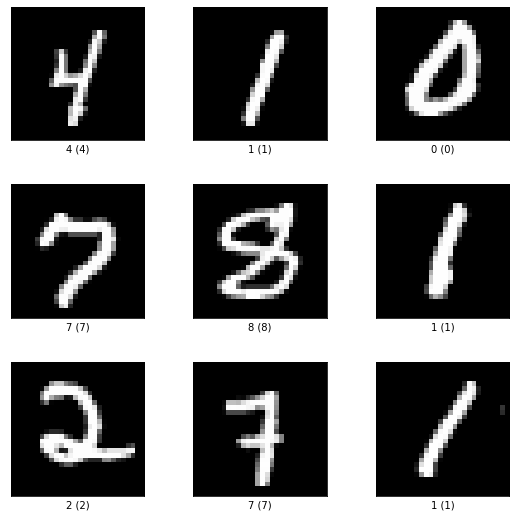

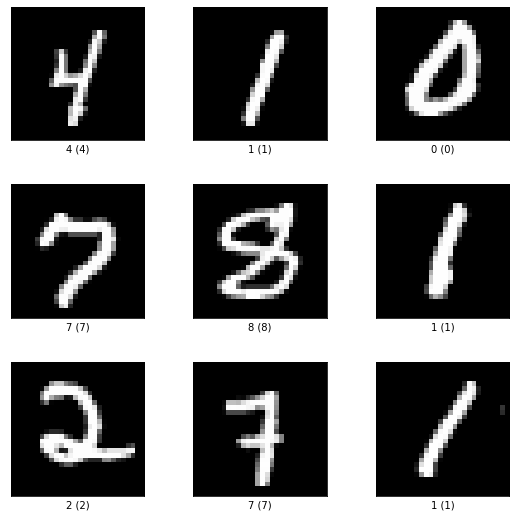

In [ ]:
tfds.show_examples(train_ds, ds_info)

## **2.1 Prepare the dataset**

---

In [ ]:
batchsize = 64
seq_len = 20

In [ ]:
def preprocess(ds, batchsize, seq_len):
    # image should be float
    ds = ds.map(lambda x, t: (tf.cast(x, tf.float32), t))
    # image vector will here have values between -1 and 1
    ds = ds.map(lambda x, t: ((x/128.)-1., t))
    # change the target
    range_vals = tf.range(seq_len)
    ds = ds.map(lambda x, t: (x, tf.where(tf.math.floormod(range_vals, 2)==0, t, -t)))
    ds = ds.map(lambda x, t: (x, (tf.math.cumsum(t))))
    # cache
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000)
    ds = ds.batch(batchsize)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

train_ds = preprocess(train_ds, batchsize, seq_len)
test_ds = preprocess(test_ds, batchsize, seq_len)

## **2.2 The CNN & LSTM model**

---

In [ ]:
class basic_CNN(tf.keras.Model):
    def __init__(self):
        super(basic_CNN, self).__init__()

        self.metrics_list = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]
        
        self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', batch_input_shape=(batchsize, seq_len, 28, 28, 1))
        self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', batch_input_shape=(batchsize, seq_len, 28, 28, 1))
        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', batch_input_shape=(batchsize, seq_len, 28, 28, 1))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.timedist = tf.keras.layers.TimeDistributed(self.global_pool)

        self.rnn = tf.keras.layers.RNN(lstm(8), return_sequences=True) 
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.outputlayer = tf.keras.layers.Dense(units=1, activation=None) 
        
    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        x = self.batchnorm1(x)
        x = self.timedist(x) 
        x = self.rnn(x)
        x = self.batchnorm2(x)
        x = self.outputlayer(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        img, label = data

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction)

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}
     

## **2.3 LSTM AbstractRNNCell layer**
---

In [ ]:
class lstm(tf.keras.layers.AbstractRNNCell):

    def __init__(self, units):
        super(lstm, self).__init__()

        self.units = units

        self.forgetgate = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), activation='sigmoid')
        self.inputgate1 = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), activation='sigmoid')
        self.inputgate2 = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), activation='tanh')
        self.outputgate = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None), activation='sigmoid')
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.units]), 
                tf.TensorShape([self.units])]

    @property
    def output_size(self):
        return [tf.TensorShape([self.units])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([batch_size, self.units]), 
                tf.zeros([batch_size, self.units])]

    def call(self, inputs, states):
        cell_s = states[0]
        hidden_s = states[1]

        concat_value = tf.concat([inputs, hidden_s], axis=-1)

        x1 = self.forgetgate(concat_value)
        x1 = tf.math.multiply(x1, cell_s)

        x2 = self.inputgate1(concat_value)
        x3 = self.inputgate2(concat_value)

        x3 = tf.math.multiply(x2, x3)
        new_cell_s = tf.math.add(x1, x3)

        x4 = self.outputgate(concat_value)
        new_hidden_s = tf.math.multiply(x4, tf.math.tanh(new_cell_s))

        return new_hidden_s, (new_hidden_s, new_cell_s)

    def get_config(self):
        return {"hidden_units": self.units}

## **2.6 Training**
---

We encountered errors in this part, and couldn't proceed to visualizing data. 

In [ ]:
epochs = 15
lr = 1e-2

model = basic_CNN()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=loss, optimizer=optimizer)

In [ ]:
EXPERIMENT_NAME = "CNN_LSTM"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [ ]:
history = model.fit(train_ds, 
                    validation_data=test_ds, 
                    epochs=epochs,
                    batch_size=batchsize,
                    callbacks=[logging_callback])

Epoch 1/15


ValueError: ignored

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training","validation"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.show()

NameError: ignored